In [1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn.functional as F
from sklearn import linear_model

plt.rcParams["figure.dpi"] = 300
sns.set_theme(style="whitegrid")
plt.rcParams.update(
    {
        "axes.linewidth": 1,
    }
)

img_size_list = [96, 112, 128, 160, 192, 224]

costs = {
    0.7: [
        557984640,
        753287424,
        974573952,
        1518407808,
        2198775168,
        3019433856,
    ],
    1.0: [
        811149696,
        1102108416,
        1441700736,
        2273642880,
        3322901376,
        4608940416,
    ],
}

In [2]:
def get_dfs(dump_file, cost):
    with open(dump_file, "rb") as f:
        dump = pickle.load(f)
    images = pd.Series(dump["images"])

    idx_to_keep = images[~images.duplicated(keep="first")].index.to_list()
    images_count = len(idx_to_keep)
    train_idx = np.linspace(5, images_count - 5, 1000).round().astype(int)
    test_idx = np.setdiff1d(np.arange(images_count), train_idx)
    images_count_test = len(test_idx)

    target = dump["target"][idx_to_keep]
    target_test = target[test_idx]

    outputs = dump["outputs"][:, idx_to_keep, :]
    outputs_test = outputs[:, test_idx, :]

    hit1_minres = (
        pd.DataFrame((outputs.argmax(dim=2) == target.unsqueeze(0)).nonzero())
        .groupby(1)
        .min()
        .to_dict()[0]
    )
    hit1_minres = np.array(
        [hit1_minres[i] if i in hit1_minres else 7 for i in range(images_count)]
    )
    hit1_minres_train = hit1_minres[train_idx]

    def evaluate_choice(which=None, first_pass=-1, pure=5):
        if which is None:
            first_pass = -1
            which = [pure] * images_count_test
        pred = outputs_test.argmax(dim=2)
        better_pred = pred[which, range(pred.shape[1])]
        which_value_counts = np.bincount(which, minlength=len(img_size_list))
        if first_pass >= 0:
            which_value_counts[first_pass] = images_count_test
        return (better_pred == target_test.unsqueeze(0)).sum().item() / len(
            target_test
        ) * 100, sum(
            cost[i] * v for i, v in enumerate(which_value_counts)
        ) / images_count_test

    acc_cost_ori = pd.DataFrame(
        [evaluate_choice(pure=i) for i in range(len(img_size_list))]
    )
    acc_cost_ori["label"] = "original"

    acc_cost_all_list = [acc_cost_ori]
    for i in range(4):
        confidence = F.softmax(outputs[i], dim=1).var(dim=1).numpy()
        confidence = 0.3 ** (confidence / confidence.mean())
        confidence_train = confidence[train_idx]
        confidence_test = confidence[test_idx]
        if i == 0:
            confidence_96_train = confidence_train

        reg = linear_model.LinearRegression()
        reg.fit(
            np.concatenate([confidence_train.reshape(-1, 1)], axis=1), hit1_minres_train
        )

        acc_cost_new_list = []
        for j in np.arange(0.2, 5, 0.1):
            which = (
                np.clip(
                    reg.predict(
                        np.concatenate([confidence_test.reshape(-1, 1)], axis=1)
                    ),
                    0,
                    5,
                )
                * j
            )
            which = np.clip(np.round(which), i, 5).astype(int)
            acc_cost_new_list.append(evaluate_choice(which, first_pass=i))
        acc_cost_new = pd.DataFrame(acc_cost_new_list)
        acc_cost_new["label"] = f"1st pass res. {img_size_list[i]}"
        acc_cost_all_list.append(acc_cost_new)

    acc_cost_all = pd.concat(acc_cost_all_list)

    return confidence_96_train, hit1_minres_train, acc_cost_all, acc_cost_ori

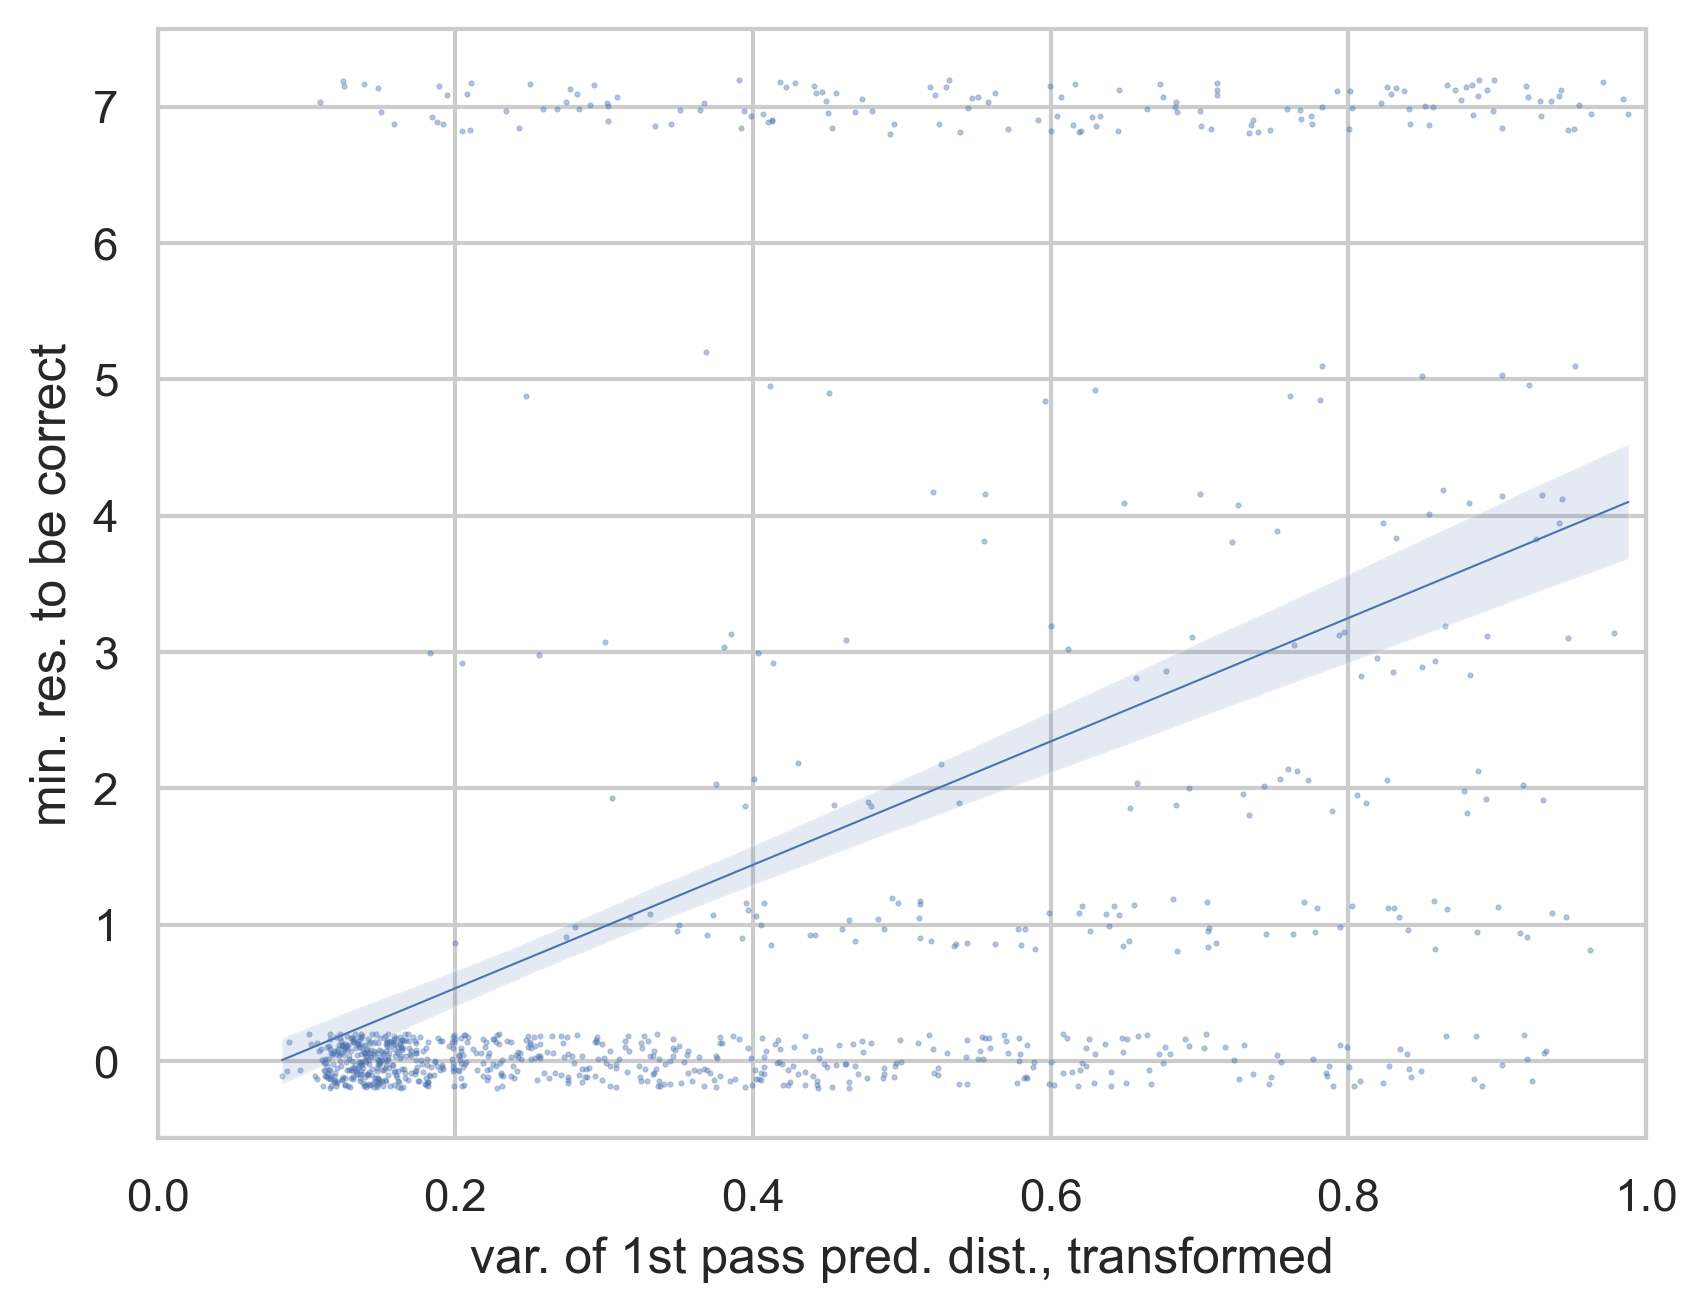

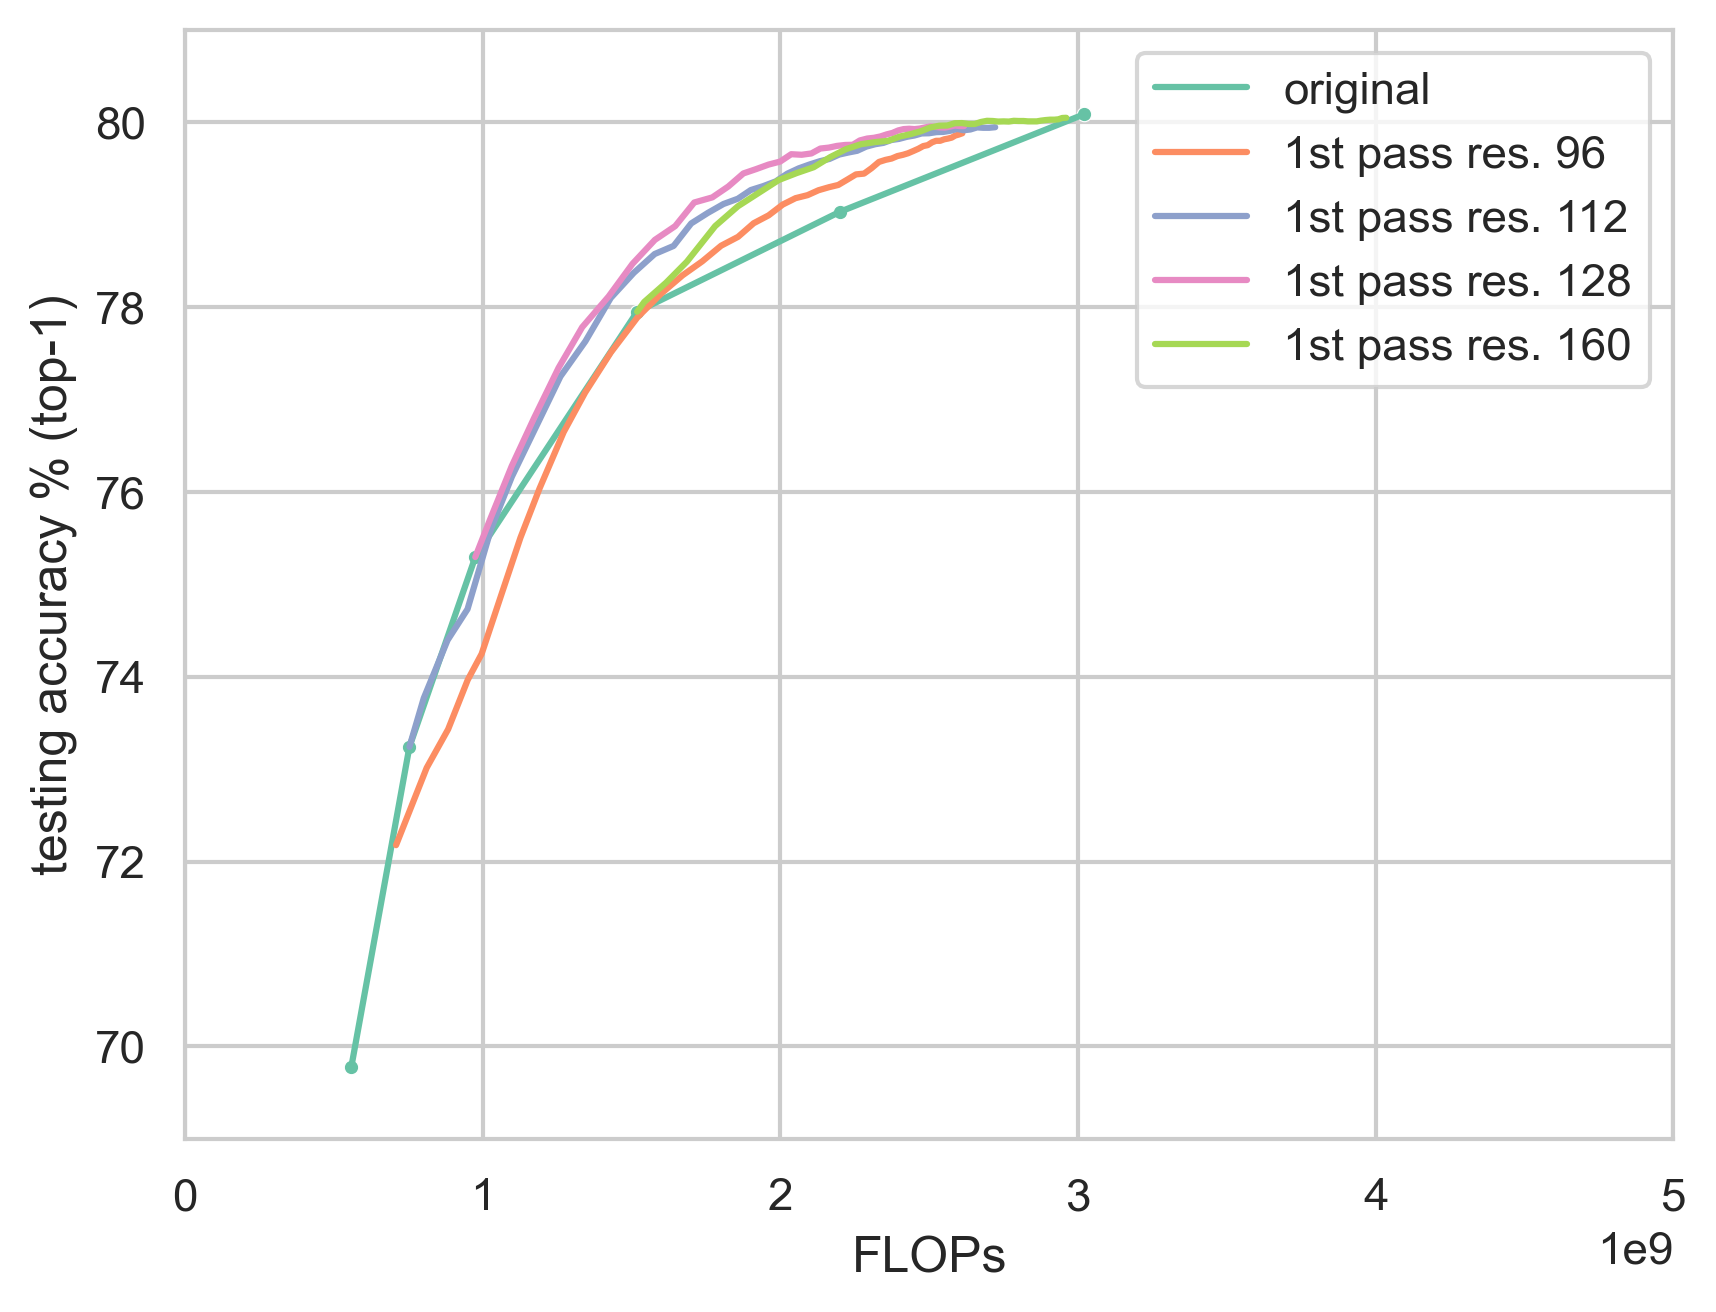

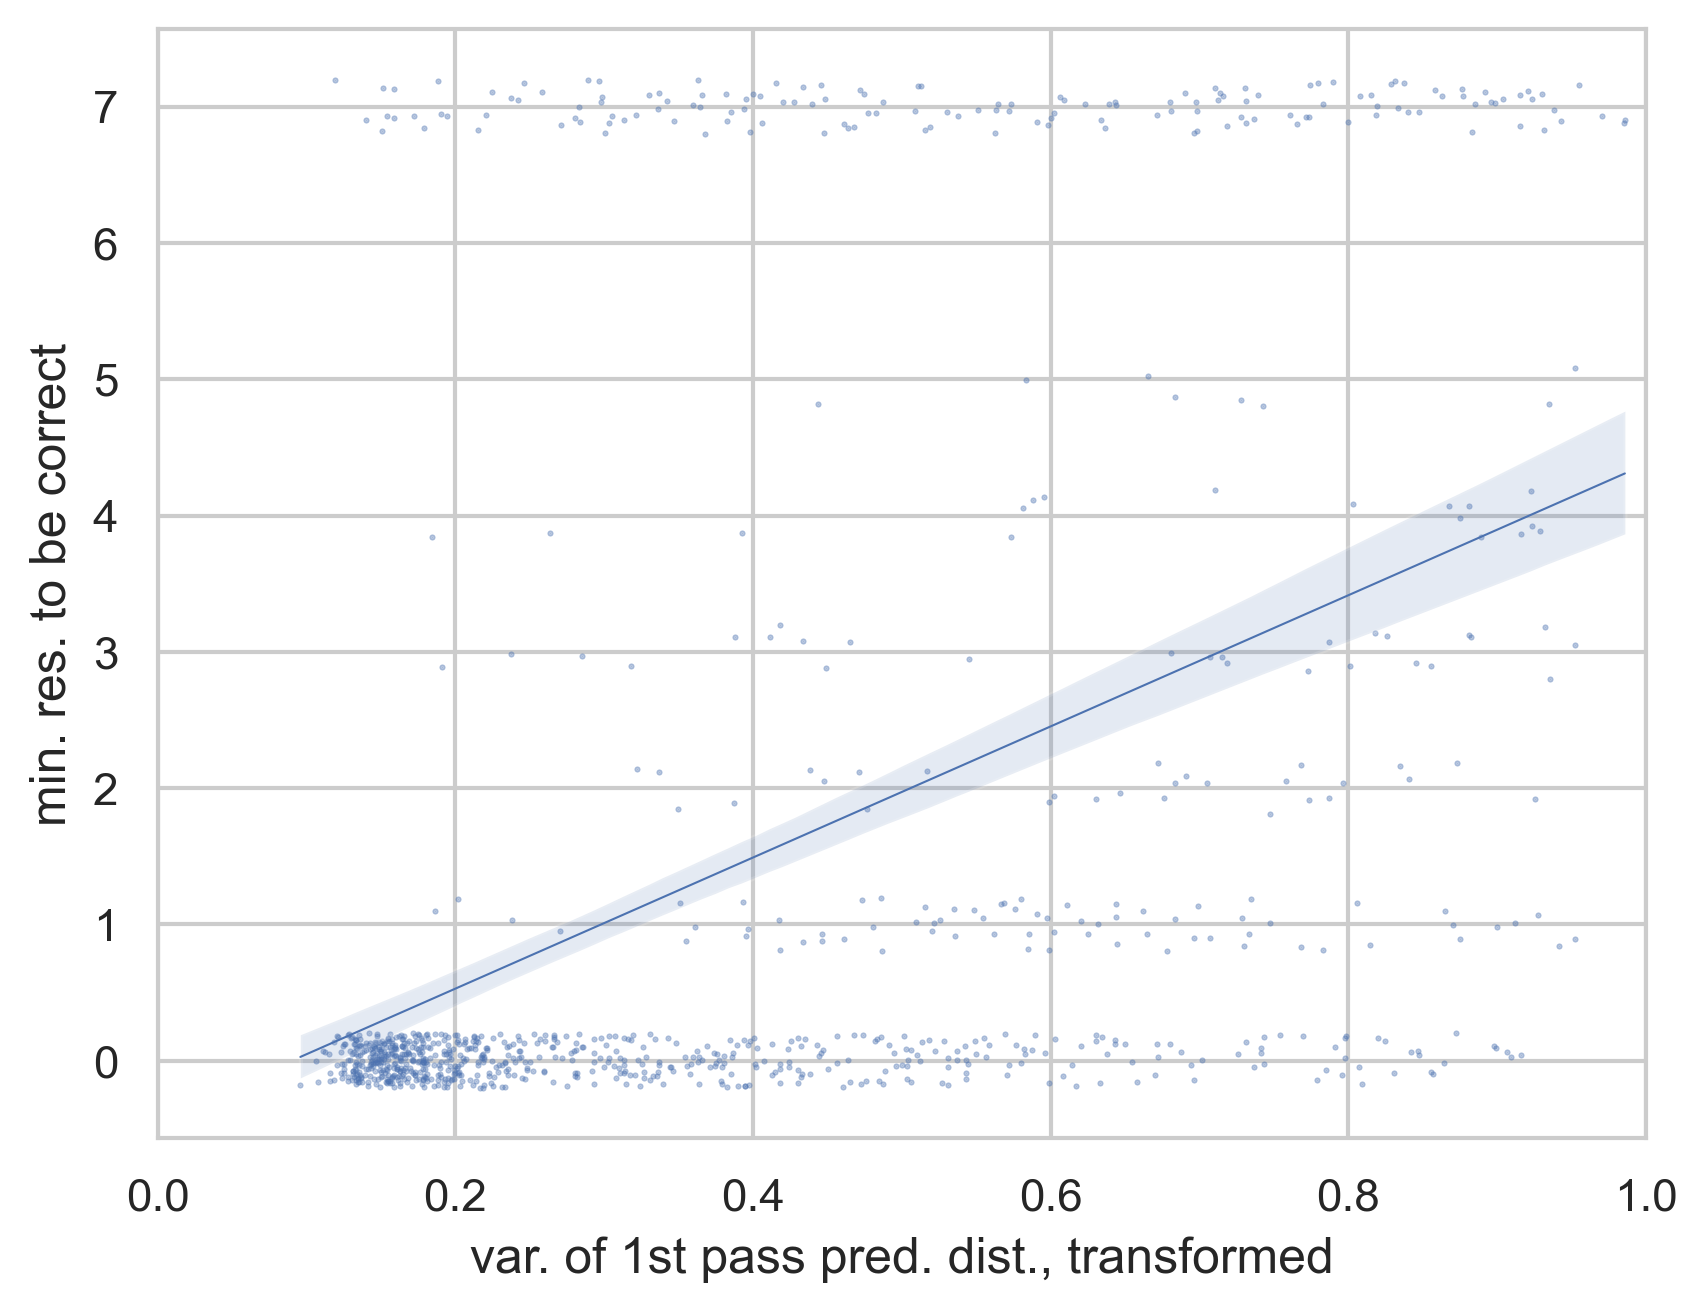

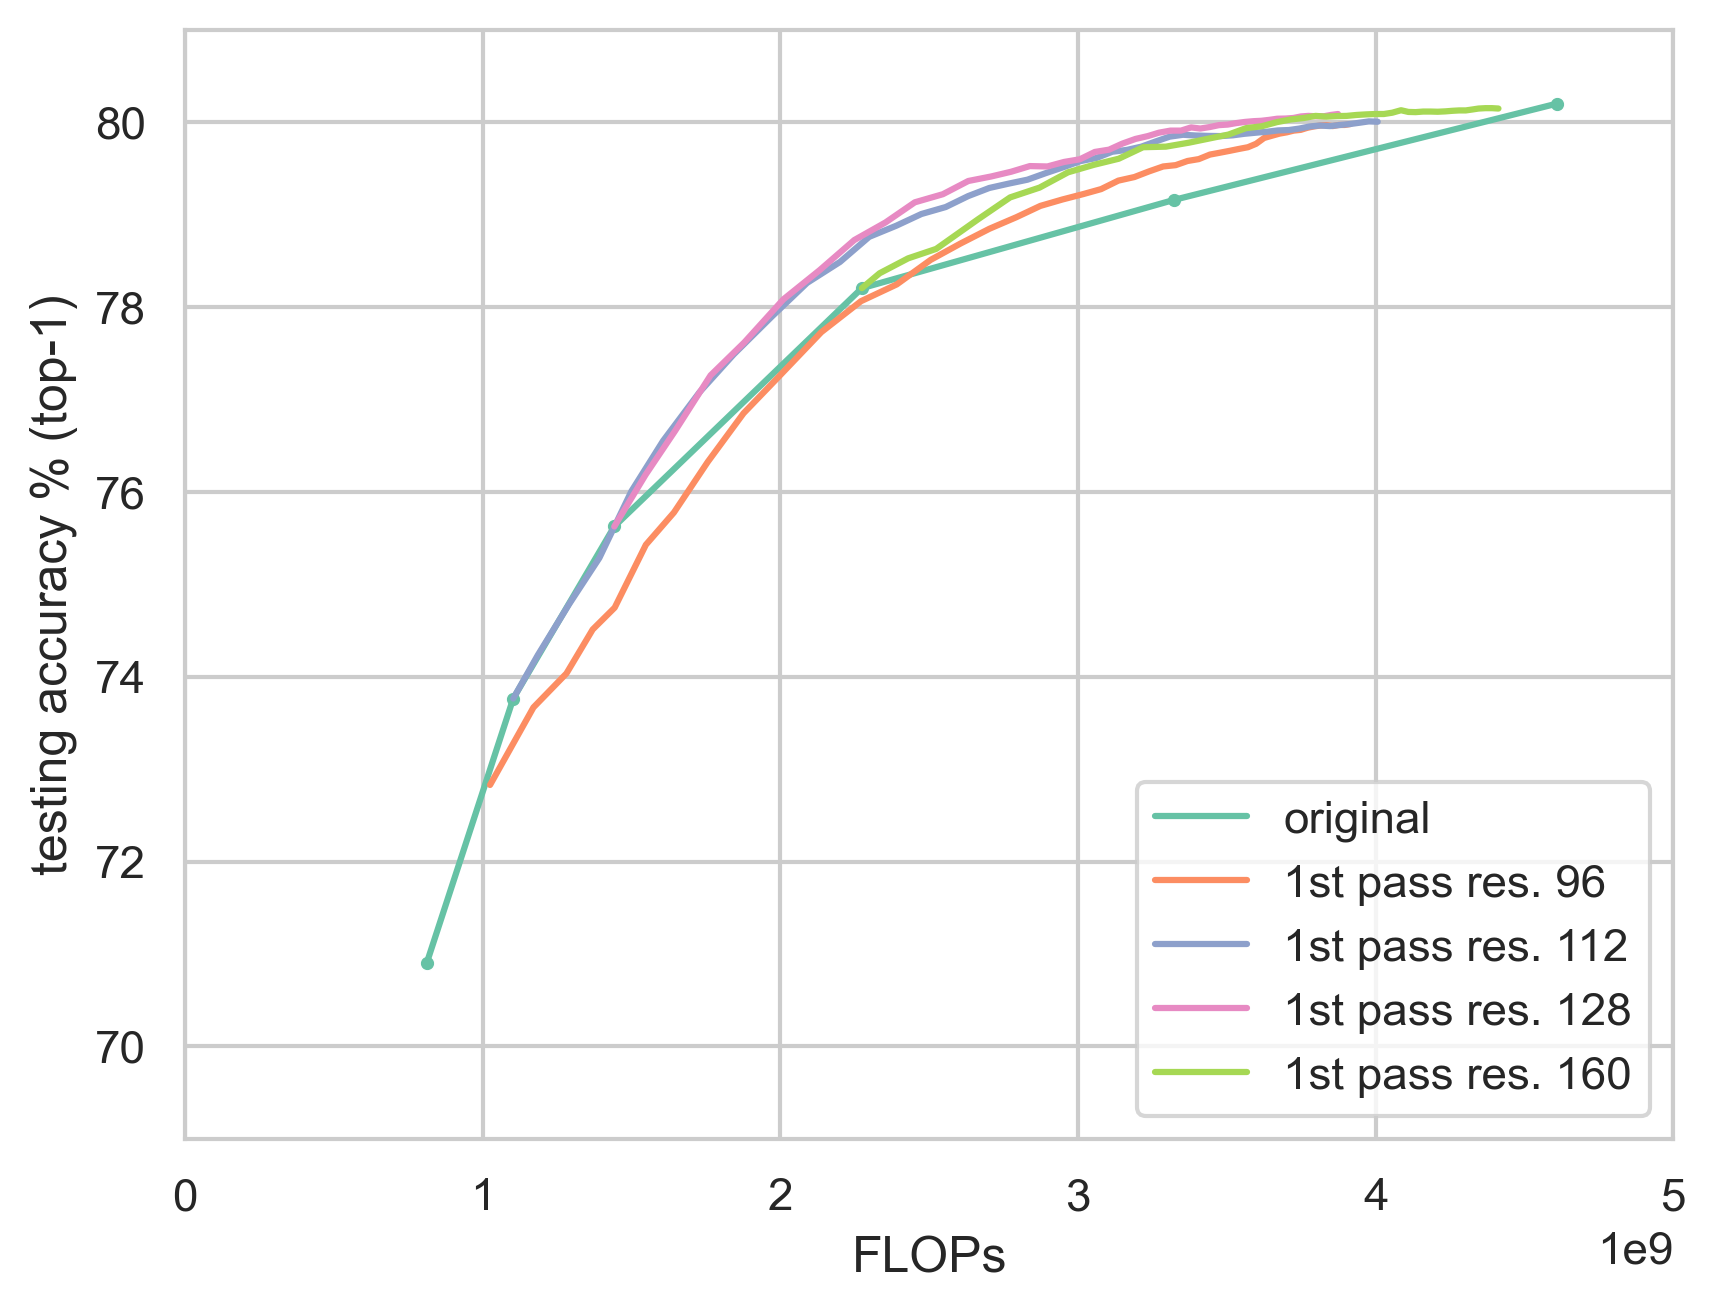

In [3]:
for rate in [0.7, 1.0]:
    confidence_96_train, hit1_minres_train, acc_cost_all, acc_cost_ori = get_dfs(
        f"dump_{rate}.pkl", costs[rate]
    )

    fig, ax = plt.subplots()
    sns.regplot(
        x=confidence_96_train,
        y=hit1_minres_train,
        y_jitter=0.2,
        scatter_kws={"s": 0.2, "alpha": 0.5},
        line_kws={"lw": 0.5},
        ax=ax,
    )
    plt.xlabel("var. of 1st pass pred. dist., transformed")
    plt.ylabel("min. res. to be correct")
    plt.xlim(0, 1)
    plt.savefig(f"reg_plot_{rate}.svg")
    plt.savefig(f"reg_plot_{rate}.png")

    fig, ax = plt.subplots()
    sns.lineplot(
        hue="label",
        data=acc_cost_all,
        x=1,
        y=0,
        ax=ax,
        palette="Set2",
    )
    sns.scatterplot(
        acc_cost_ori, x=1, y=0, s=12, ax=ax, color=sns.color_palette("Set2")[0]
    )
    plt.xlabel("FLOPs")
    plt.ylabel("testing accuracy % (top-1)")
    plt.xlim(0, 5e9)
    plt.ylim(69, 81)
    plt.savefig(f"test_acc_{rate}.svg")
    plt.savefig(f"test_acc_{rate}.png")